In [3]:
# Установить зависимости
%pip install -U scikit-learn pandas matplotlib xgboost seaborn

Note: you may need to restart the kernel to use updated packages.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   2075259 non-null  object 
 1   Time                   2075259 non-null  object 
 2   Global_active_power    2049280 non-null  float64
 3   Global_reactive_power  2049280 non-null  float64
 4   Voltage                2049280 non-null  float64
 5   Global_intensity       2049280 non-null  float64
 6   Sub_metering_1         2049280 non-null  float64
 7   Sub_metering_2         2049280 non-null  float64
 8   Sub_metering_3         2049280 non-null  float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   


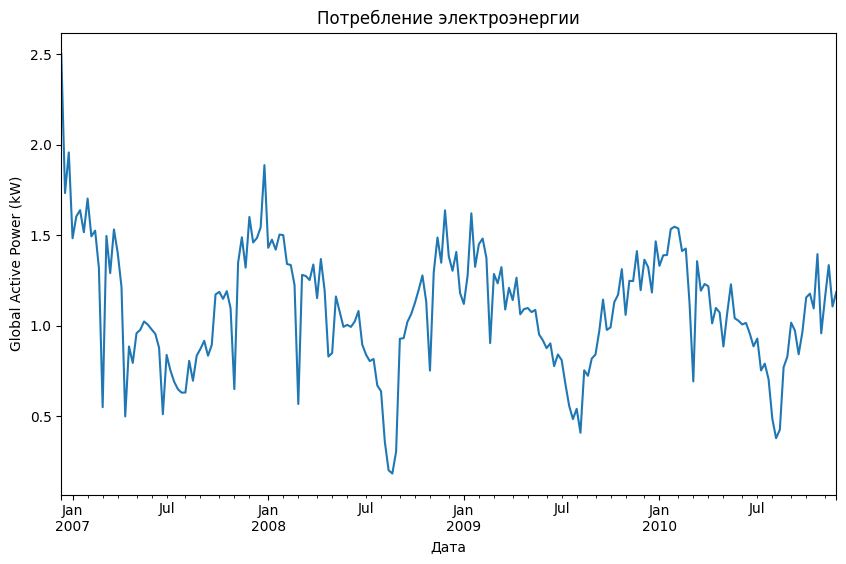

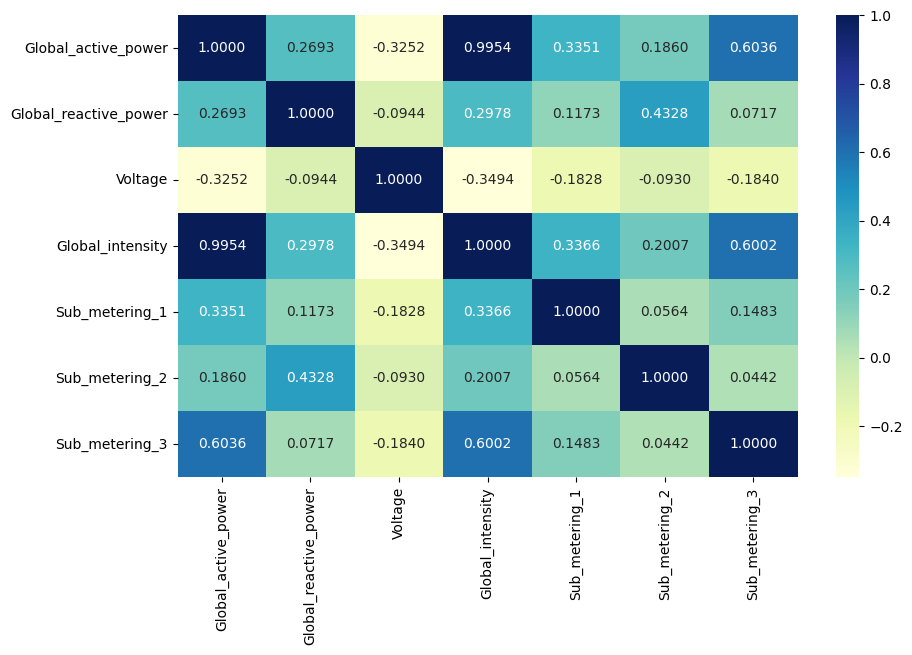

Результаты:
MAE: 0.27
RMSE: 0.38
R^2: 0.82


<Figure size 1000x600 with 0 Axes>

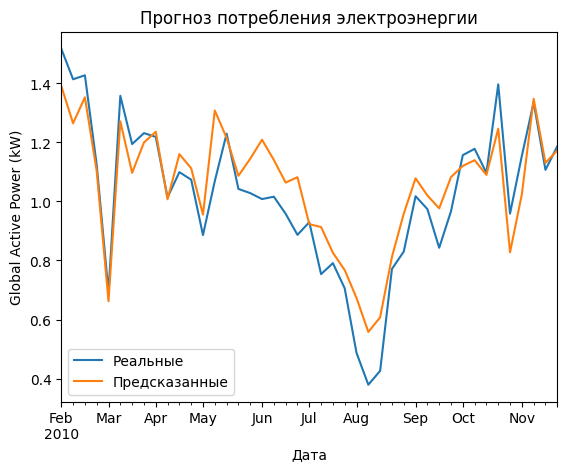

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from xgboost import XGBRegressor

# Прочитать датасет из CSV файла внутри ZIP файла (разделитель `;`) и заменить все ? на nan'ы
df = pd.read_csv('HW1_2_dataset.zip', sep=';', low_memory=False, na_values=['?'])

# Вывод инфы про столбцы, недостающие значения, типы данных, а также несколько первых записей и т.д.
df.info(show_counts=True)
print(df.head())

# Объединяем дату и время в тип данных datetime64, удаляем ненужные столбцы и строки и назначаем столбец DateTime как индексный
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df.drop(columns=['Date', 'Time'], inplace=True)
df.dropna(inplace=True)
df.set_index('DateTime', inplace=True)

print('Начальная дата', df.index.min())
print('Окончательная дата', df.index.max())

# Визуализация
df_power_week = df['Global_active_power'].resample('W').mean()

plt.figure(figsize=(10, 6))
df_power_week.plot()
plt.title('Потребление электроэнергии')
plt.xlabel('Дата')
plt.ylabel('Global Active Power (kW)')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".4f", cmap="YlGnBu")
plt.show()

# Определяем признаки (выбрасываем Global_intensity поскольку корреляция >= 0.7) и целевую переменную
X = df.drop(columns=['Global_intensity', 'Global_active_power'])
y = df['Global_active_power']

# Разделить на тренировочкую (80%) и тестовую выборки (20%) (shuffle=False поскольку важен порядок по датам)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Тренируем модель
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

# Предсказываем
y_pred = model.predict(X_test)

# Анализ результатов
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Результаты:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Визуализация
df_pred_week = pd.DataFrame({
    'DateTime': X_test.index, 
    'Реальные': y_test, 
    'Предсказанные': y_pred
})

df_pred_week.set_index('DateTime', inplace=True)
df_pred_week = df_pred_week.resample('W').mean()

plt.figure(figsize=(10, 6))
df_pred_week.plot()
plt.legend()
plt.title('Прогноз потребления электроэнергии')
plt.xlabel('Дата')
plt.ylabel('Global Active Power (kW)')
plt.show()